In [1]:
import glob
import os
from datetime import datetime, timedelta, date
from os import path

In [2]:
folder = "./nhscovid"
ext = "log"
ntot = 20
tstep = 2
start_sim = datetime.strptime("2020-03-05 13:30", '%Y-%m-%d %H:%M')
stop_sim = datetime.strptime("2020-03-05 14:15", '%Y-%m-%d %H:%M')

# folder = "./furc222"
# ext = "log"
# ntot = 300
# tstep = 15
# start_sim = datetime.strptime("2020-02-22 7:30", '%Y-%m-%d %H:%M')
# stop_sim = datetime.strptime("2020-02-22 16:30", '%Y-%m-%d %H:%M')

# folder = "./sma125"
# ext = "txt"
# ntot = 200
# tstep = 5
# start_sim = datetime.strptime("2019-12-05 13:40", '%Y-%m-%d %H:%M')
# stop_sim = datetime.strptime("2019-12-05 15:30", '%Y-%m-%d %H:%M')

# folder = "./shanghai19"
# ext = "txt"
# ntot = 60
# tstep = 5
# start_sim = datetime.strptime("2019-09-10 21:30", '%Y-%m-%d %H:%M')
# stop_sim = datetime.strptime("2019-09-11 01:00", '%Y-%m-%d %H:%M')

# folder = "./sma19"
# ext = "txt"
# ntot = 170
# tstep = 5
# start_sim = datetime.strptime("2019-03-14 13:30", '%Y-%m-%d %H:%M')
# stop_sim = datetime.strptime("2019-03-14 16:30", '%Y-%m-%d %H:%M')

# folder = "./broad15"
# ext = "log"
# ntot = 50
# tstep = 15
# start_sim = datetime.strptime("2019-12-10 09:00", '%Y-%m-%d %H:%M')
# stop_sim = datetime.strptime("2019-12-10 17:00", '%Y-%m-%d %H:%M')

# Coded outcomes:
# 0 = not information
# 1 = became infected, but no outcome (yet) known
# 2 = recovered
# 3 = dead
# 4 = escaped
# 10 = infected others, but has not outcome, so it is considered an initial node
color_dict = {0: "Lime Green", 1: "Dark Orange", 2: "Dodger Blue", 3: "Black", 4:"Orchid", 10:"White"}    

output = "./output"
if not path.exists(output):
    os.mkdir(output)

In [6]:
# Load all log files

files = [f for f in glob.glob(folder + "**/*." + ext, recursive=False)]

min_time = 1E10
max_time = 0
users = {}
inf_users = {}
inf_cases = []
noninf_cases = []
esc_cases = []
for fn in files:
    bname = path.basename(fn)
    idx = bname.rfind('-')
    case_id = bname[0:idx]
    events = []
    infected = False
    escaped = False    
    with open(fn, 'r') as f:
        lst = list(enumerate(f))
        n = len(lst)

        for i, line in lst:
            if i == 0 or i == n - 1:
                continue
            line = line.strip()
            line = line[1:-2]
            parts = line.split(',')
            time = int(parts[0].split(':')[1])

            evstr = parts[1]
            idx = evstr.find(':')
            evtyp = evstr[0:idx]
            if idx < len(evstr):
                evdat = evstr[idx+1:]
            else:
                evdat = None

            # print(time, evtyp, evdat)
            events += [{"time": time, "type": evtyp, "data": evdat}]
            
            if evtyp == "OUT" and evdat in ["DEAD", "RECOVERED"]:
                infected = True

            if evtyp == "OUT" and evdat == "ESCAPED":
                escaped = True                
                
            if evtyp == "INF" and "PEER" in evdat:
                pstr = evdat[5:-1]
                if ":" in pstr:
                    pieces = pstr.split(":")
                    pid = pieces[0]
                else:
                    pid = pstr
                if pid in inf_users:
                    inf_users[pid] = inf_users[pid] + 1
                else:
                    inf_users[pid] = 1
                
            min_time = min(min_time, time)
            max_time = max(max_time, time)            
    
    # Events are stored last to first in log files, reverting the order
    events.reverse()
    users[case_id] = events
    
    if infected:
        inf_cases += [case_id]
    else:
        noninf_cases += [case_id]
        if escaped:
            esc_cases += [case_id]

for pid in inf_users:
    if pid in noninf_cases:
        # This is a user that does not have an outcome but infected other users, 
        # so it is considered infected
        inf_cases += [pid]
        noninf_cases.remove(pid)
        
# The infected cases are indexed first, to facilitate removal of non-infected cases
# when plotting the tree-oriented network
count = 0
user_index = {}
for cid in inf_cases:
    user_index[cid] = count
    count += 1
for cid in noninf_cases:
    user_index[cid] = count
    count += 1

print("Number of infected    :", len(inf_cases))
print("Number of non-infected:", len(noninf_cases))
print("Number of escaped:", len(esc_cases))

min_delta = timedelta(minutes=tstep)
first_date = datetime.fromtimestamp(min_time)
last_date = datetime.fromtimestamp(max_time)
print("First event:", first_date)
print("Last event :", last_date)

Number of infected    : 6
Number of non-infected: 4
Number of escaped: 0
First event: 2020-03-05 13:30:12
Last event : 2020-03-05 13:51:26


In [7]:
# The function in this cell constructs the infection network for a given time point

# For debugging
# frange = range(20, 24)

def construct_network(td, nt, fr = -1, log = True):
    inf_network = []
    user_outcome = [0] * nt
    
#     if fr in frange:
#         print("*****", fr, "******")
    
    ninf = 0
    nknown = 0
    nmiss = 0
    nsurv = 0
    ndead = 0
    nesc = 0
    npeer = 0
    parents = {}
    first_inf = {}
    first_orph = {}
    infected = {}
    orphaned = {}
    for key in users:
        events = users[key]
        idx = user_index[key]
        if len(events) == 0: continue
        pkey = ""
        infect = None
        has_inf_event = False
        has_vax_event = False
        for ev in events:
            date = datetime.fromtimestamp(ev["time"])
            if td <= date: continue
            str_date = date.strftime('%H:%M:%S')
            data = ev["data"]
            if ev["type"] == "OUT":
                if data == "VACCINATED":
                    has_vax_event = True
                else:    
                    if data == "RECOVERED":
                        user_outcome[user_index[key]] = 2
                        nsurv += 1
                    elif data == "DEAD":
                        user_outcome[user_index[key]] = 3
                        ndead += 1
                    elif data == "ESCAPED":
                        user_outcome[user_index[key]] = 4
                        nesc += 1                        
                    if not infect:
                        # Infection edge without origin
                        infect = [{"a":"unk", "b":key, "t":str_date, "s":"-"}]
                        orphaned[key] = date
                    if has_inf_event: 
                        ninf += 1
            elif ev["type"] == "INF":
                if pkey:
                    # Duplicated parent, skipping
                    continue
                if "PEER" in data:
                    user_outcome[idx] = 1
                    pstr = data[5:-1]
                    if ":" in pstr:
                        pieces = pstr.split(":")
                        pkey = pieces[0]
                        strain = pieces[1]
                    else:
                        pkey = pstr
                        strain = "0"
                    if pkey in users:
                        # print(strain, pkey, "->", key)
#                         if fr in frange:
                        if pkey in parents:
                            if date < parents[pkey]:
                                parents[pkey] = date
                        else:
                            parents[pkey] = date
                        infect = [{"a":pkey, "b":key, "t":str_date, "s": strain}]
                        npeer += 1
                        has_inf_event = True
                    else:
                        infect = [{"a":"unk", "b":key, "t":str_date, "s": strain}]
                        has_inf_event = False
                elif "CASE0" in data:
                    user_outcome[idx] = 10
                    strain = data[6:-1]
                    # print(strain, "0", "->", key)
                    infect = [{"a":"zero", "b":key, "t":str_date, "s": strain}]
                    has_inf_event = True
                    first_inf[idx] = date
                elif "SOURCE" in data:
                    user_outcome[idx] = 10
                    if ":" in data:
                        strain = pieces[1]
                    else:
                        strain = "0"
                    infect = [{"a":"src", "b":key, "t":str_date, "s": strain}]
                    has_inf_event = True
                    first_inf[idx] = date

        if has_vax_event: 
            continue
            
        if has_inf_event:
            nknown += 1
        else:
            nmiss += 1
        infected[idx] = has_inf_event

        if infect:
            inf_network += infect

    if log:
        print("  Total number of cases:", ninf)
        print("  Total number of deaths:", ndead)
        print("  Total number of escaped:", nesc)        
        print("  Total number of survivors:", nsurv)
        print("  Number of infections with known source:", nknown)
        print("  Number of infections from peer:", npeer)
        print("  Number of infections with missing source:", nmiss)

    # Finalizing outcomes and first infections based on ancilliary info
    
    for p in parents:
        idx = user_index[p]
        if user_outcome[idx] == 0:
            # This user infected others but not yet had an outcome, so marked as initial node (10)
            user_outcome[idx] = 10
        if not idx in infected or not infected[idx]:
            # Not infected by anybody else, so it is a first case
            first_inf[idx] = parents[p]

    for o in orphaned:
        # Orphan nodes are those who had an outcome but not infecting parent, 
        # and did not infected anybody else
        idx = user_index[o]
        if not idx in first_inf:
            first_inf[idx] = orphaned[o]

    return inf_network, user_outcome, first_inf, ninf, ndead, nsurv

In [12]:
# Plot infection network using igraph
# https://igraph.org/python/

from igraph import *

td = first_date
frame = 0
while td <= last_date + min_delta:
    td += min_delta
    print("-> Frame:", frame, "- Time:", td)
    network, outcomes, _, _, _, _ = construct_network(td, ntot, frame)

    g = Graph(directed=True)
    g.add_vertices(ntot)

    g.vs["outcome"] = outcomes
    g.vs["color"] = [color_dict[out] for out in g.vs["outcome"]]

    for edge in network:
        n0 = edge["a"]
        n1 = edge["b"]
        if n0 in user_index and n1 in user_index:
#             print(user_index[n0], "->", user_index[n1])
            g.add_edges([(user_index[n0], user_index[n1])])

#     print(g)

    layout = g.layout("fr", maxiter=500)
    p = plot(g, layout = layout, vertex_size = 9, edge_arrow_width = 1, edge_arrow_size = 0.5, 
             bbox=(0, 0, 800, 800))
    
#     if frame in frange:   
    p.save(os.path.join(output, "frame-" + str(frame) + td.strftime('-%H-%M') + ".png"))
    frame += 1

-> Frame: 0 - Time: 2020-03-05 13:32:12
  Total number of cases: 0
  Total number of deaths: 0
  Total number of escaped: 0
  Total number of survivors: 0
  Number of infections with known source: 3
  Number of infections from peer: 2
  Number of infections with missing source: 6
-> Frame: 1 - Time: 2020-03-05 13:34:12
  Total number of cases: 0
  Total number of deaths: 0
  Total number of escaped: 0
  Total number of survivors: 0
  Number of infections with known source: 4
  Number of infections from peer: 3
  Number of infections with missing source: 5
-> Frame: 2 - Time: 2020-03-05 13:36:12
  Total number of cases: 3
  Total number of deaths: 0
  Total number of escaped: 0
  Total number of survivors: 3
  Number of infections with known source: 5
  Number of infections from peer: 4
  Number of infections with missing source: 4
-> Frame: 3 - Time: 2020-03-05 13:38:12
  Total number of cases: 4
  Total number of deaths: 0
  Total number of escaped: 0
  Total number of survivors: 4
  

In [9]:
# Plot tree-orientated network

network, outcomes, initial, _, _, _ = construct_network(last_date + min_delta, ntot)

seeds = []
for s in initial:
    seeds += [s]

succeptibles = []
for idx in range(ntot):
    if outcomes[idx] == 0:
        succeptibles += [idx]
    if outcomes[idx] == 10:
        seeds += [idx]
        
# print(outcomes)
# print(seeds)
# print(succeptibles)

g = Graph(directed=True)
g.add_vertices(ntot)

g.vs["outcome"] = outcomes
g.vs["color"] = [color_dict[out] for out in g.vs["outcome"]]

for edge in network:
    n0 = edge["a"]
    n1 = edge["b"]
    if n0 in user_index and n1 in user_index:
        g.add_edges([(user_index[n0], user_index[n1])])

# Removing non-infected, assuming they are all after the infected
g.delete_vertices(succeptibles)
        
layout = g.layout("rt", mode="out", root = seeds, rootlevel = [1] * len(seeds))
p = plot(g, layout = layout, vertex_size = 16, edge_arrow_width = 1, edge_arrow_size = 0.9, 
         bbox=(0, 0, 800, 800))

p.save(os.path.join(output, "infection-tree.png"))

  Total number of cases: 6
  Total number of deaths: 0
  Total number of escaped: 0
  Total number of survivors: 6
  Number of infections with known source: 6
  Number of infections from peer: 4
  Number of infections with missing source: 3


[20, 20, 20, 17, 16, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
[0, 0, 0, 3, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 3, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[0, 0, 0, 3, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


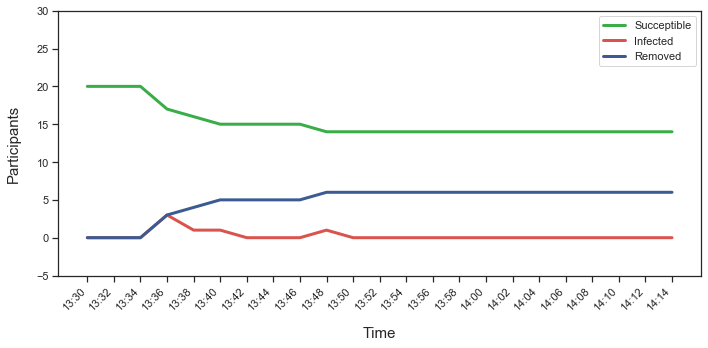

<Figure size 432x288 with 0 Axes>

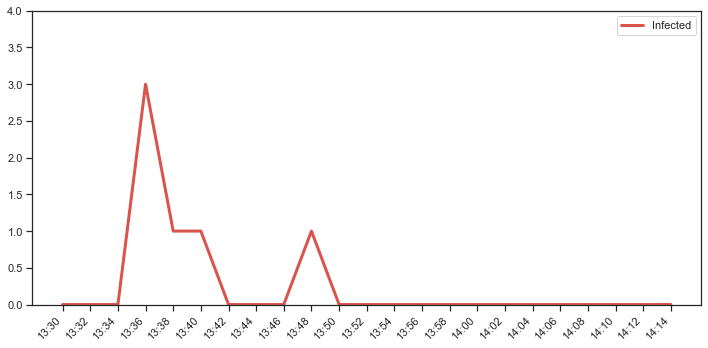

<Figure size 432x288 with 0 Axes>

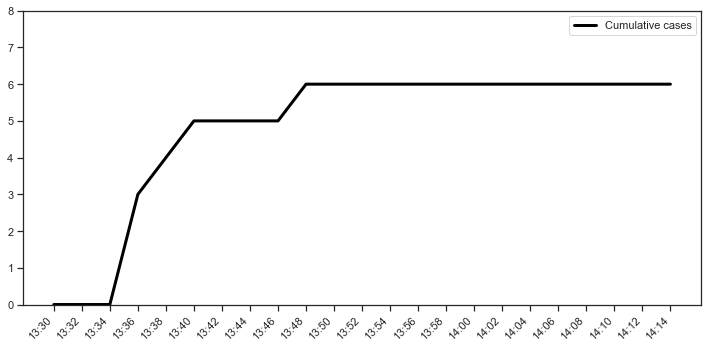

In [10]:
# Plot epi curves

import matplotlib.pyplot as plt
%matplotlib inline

# Styling with seaborn:
import seaborn as sns
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set()
sns.set_style("ticks")

S = []
I = []
R = []
C = []
time = []
tlabels = []

td = start_sim
ninf0 = 0
t = 0
while td <= stop_sim:
    _, _, _, ninf, ndead, nsurv = construct_network(td, ntot, log = False)
#     print(td.strftime('%H:%M'), ninf, ndead, nsurv)
    dinf = ninf - ninf0
    ninf0 = ninf
    S += [ntot - (ndead + nsurv)]    
    I += [dinf]
    R += [ndead + nsurv]
    C += [ninf]
    time += [t]
    tlabels += [td.strftime('%H:%M')]
    td += min_delta
    t += 1

print(S)
print(I)
print(R)
print(C)

# Combined SIR curves
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([-5, ntot + 10])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Participants", labelpad=15, fontsize=15)
ax.plot(time, S, label="Succeptible", color=sns.xkcd_rgb["medium green"], lw=3)
ax.plot(time, I, label="Infected", color=sns.xkcd_rgb["pale red"], lw=3)
ax.plot(time, R, label="Removed", color=sns.xkcd_rgb["denim blue"], lw=3)
plt.xticks(time, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output, "epi-curves.pdf"))

# I plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(I) * 1.2)])
ax.plot(time, I, label="Infected", color=sns.xkcd_rgb["pale red"], lw=3)
plt.xticks(time, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output, "i-curve.pdf"))

# C plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(C) * 1.2)])
ax.plot(time, C, label="Cumulative cases", color=sns.xkcd_rgb["black"], lw=3)
plt.xticks(time, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output, "c-curve.pdf"))

[2, 1, 1]
1.3333333333333333 0.4714045207910317


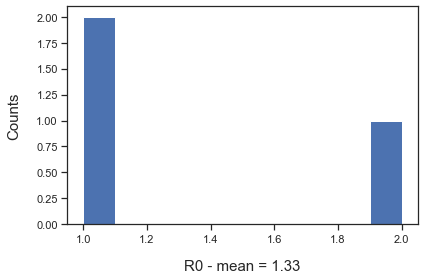

In [11]:
# Plot distribution of R0

import numpy as np

network, _, _, _, _, _ = construct_network(last_date + min_delta, ntot, log = False)

inf_counts = {}
for edge in network:
    n0 = edge["a"]
    if n0 not in ["unk", "zero", "src"]:
        if n0 in inf_counts:
            inf_counts[n0] = inf_counts[n0] + 1
        else:
            inf_counts[n0] = 1

r0_values = []
for node in inf_counts:
    r0_values += [inf_counts[node]]
print(r0_values)

r0_mean = np.mean(r0_values)
r0_std = np.std(r0_values)

print(r0_mean, r0_std)

counts, bins = np.histogram(r0_values)
plt.ylabel("Counts", labelpad=15, fontsize=15)
plt.xlabel("R0 - mean = " + str(round(r0_mean, 2)), labelpad=15, fontsize=15)
plt.hist(bins[:-1], bins, weights=counts)
plt.tight_layout()
plt.savefig(os.path.join(output, "r0-histogram.pdf"))